# Non-spatial Dispersal Coverage Test

In [1]:
import csv
import subprocess
import json

import numpy as np

from matplotlib import pyplot as plt
from scipy.stats import chisquare
from IPython.display import display, Markdown

In [2]:
target_directory = json.loads(subprocess.run("cargo metadata --format-version 1".split(), capture_output=True).stdout)["target_directory"]

In [3]:
def test_nonspatial_dispersal_coverage(
    algorithm, output_file='coverage.csv', speciation=0.001, seed=42, size=100, sample=1.0
):
    # Configure the simulation
    config = "".join("""
    (
        speciation: {speciation},
        seed: {seed},
        sample: {sample},

        algorithm: {algorithm}(),

        scenario: NonSpatial(
            area: ({size}, {size}),
            deme: {size},
        ),

        reporters: [
            Plugin(
                library: "{target_directory}/release/deps/libnecsim_plugins_statistics.so",
                reporters: [
                    GlobalCoverage(output: "{output_file}"),
                ],
            ),
        ],
    )
    """.format(
        target_directory=target_directory, output_file=output_file,
        algorithm=algorithm, speciation=speciation, seed=seed, sample=sample, size=size,
    ).split()).replace(",)", ")").replace(",]", "]")
    
    # Run the simulation
    subprocess.run(
        "cargo run --release --features rustcoalescence-algorithms-monolithic,"
        + f"rustcoalescence-algorithms-independent -- simulate '{config}'",
        shell=True, check=True,
    )
    
    # Read in the dispersal locations
    locations = []
    with open(output_file) as file:
        reader = csv.reader(file)
        next(reader)

        for row in reader:
            locations.append((int(row[0]), int(row[1]), int(row[2])))
    locations = np.array(locations)
    
    # Calculate in the dispersal locations
    gof = chisquare(np.histogramdd(locations, bins=(
        range(0, size+1), range(0, size+1), range(0, size+1)
    ))[0].flatten())
    
    if gof.pvalue <= 0.05:
        colour = 'red'
    elif gof.pvalue <= 0.1:
        colour = 'orange'
    else:
        colour = 'green'
    
    display(Markdown(f"## <span style='color:{colour}'>{algorithm}</span>"))
    display(Markdown(f"#### Chi-squared test:\n* p-value: {gof.pvalue}\n* statistic: {gof.statistic}"))
    display(Markdown(f"#### Coverage Histograms:"))
    
    # Draw the 2d dispersal coverage histograms
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

    ax1.set_title("Dispersal histogram x-y")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    hist1 = ax1.hist2d(locations[:,0], locations[:,1],
                       bins=(range(0, size+1), range(0, size+1)),
                       density=True)
    fig.colorbar(hist1[3], ax=ax1)

    ax2.set_title("Dispersal histogram x-index")
    ax2.set_xlabel("x")
    ax2.set_ylabel("index")
    hist2 = ax2.hist2d(locations[:,0], locations[:,2],
                       bins=(range(0, size+1), range(0, size+1)),
                       density=True)
    fig.colorbar(hist2[3], ax=ax2)

    ax3.set_title("Dispersal histogram y-index")
    ax3.set_xlabel("y")
    ax3.set_ylabel("index")
    hist3 = ax3.hist2d(locations[:,1], locations[:,2],
                       bins=(range(0, size+1), range(0, size+1)),
                       density=True)
    fig.colorbar(hist3[3], ax=ax3)

    plt.show()
    
    display(Markdown(f"#### Configuration:\n```rust\n{config}\n```"))

## <span style='color:green'>Classical</span>

#### Chi-squared test:
* p-value: 0.26600448536471466
* statistic: 1000882.3947209934

#### Coverage Histograms:

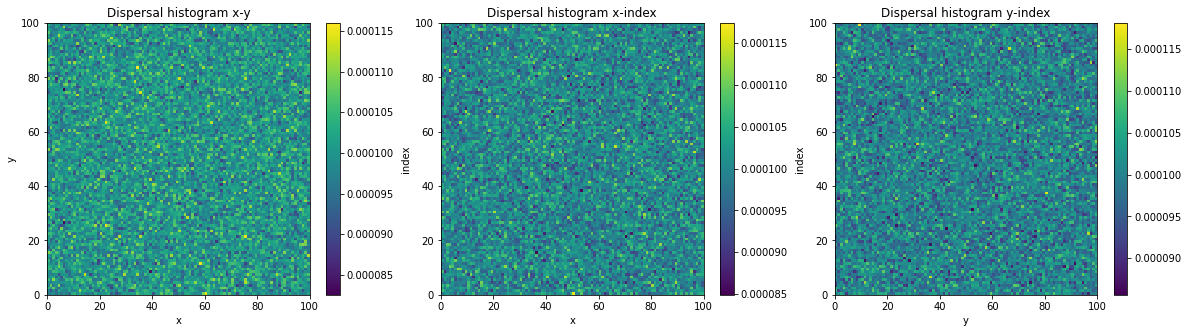

#### Configuration:
```rust
(speciation:1e-06,seed:123456789,sample:0.0001,algorithm:Classical(),scenario:NonSpatial(area:(100,100),deme:100),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"coverage.csv")])])
```

## <span style='color:green'>Gillespie</span>

#### Chi-squared test:
* p-value: 0.6460632257710456
* statistic: 999468.5024884597

#### Coverage Histograms:

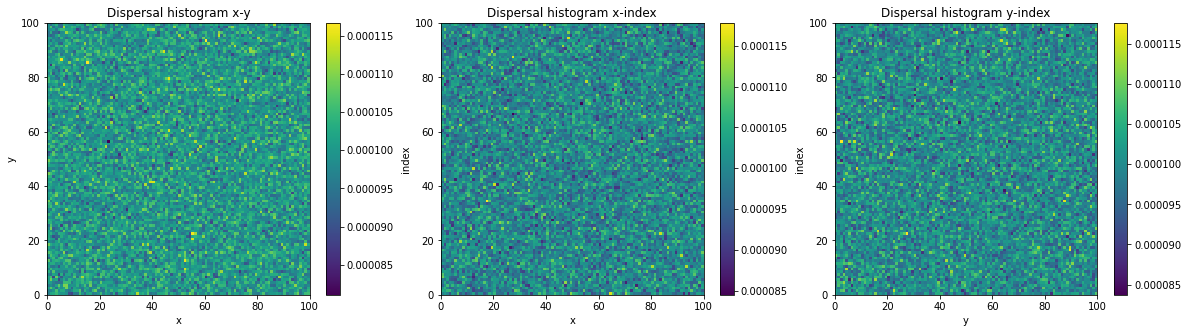

#### Configuration:
```rust
(speciation:1e-06,seed:123456789,sample:0.0001,algorithm:Gillespie(),scenario:NonSpatial(area:(100,100),deme:100),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"coverage.csv")])])
```

## <span style='color:green'>SkippingGillespie</span>

#### Chi-squared test:
* p-value: 0.8909276159560282
* statistic: 998257.7752444792

#### Coverage Histograms:

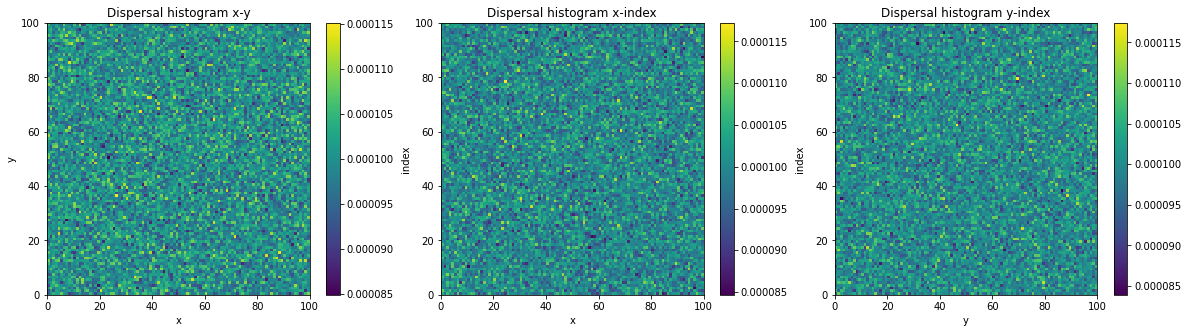

#### Configuration:
```rust
(speciation:1e-06,seed:123456789,sample:0.0001,algorithm:SkippingGillespie(),scenario:NonSpatial(area:(100,100),deme:100),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"coverage.csv")])])
```

## <span style='color:green'>Independent</span>

#### Chi-squared test:
* p-value: 0.6745706588740648
* statistic: 999358.440353353

#### Coverage Histograms:

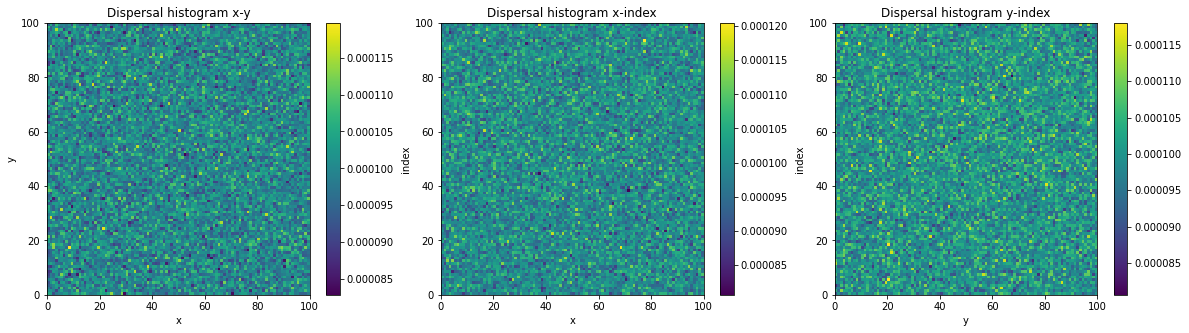

#### Configuration:
```rust
(speciation:1e-06,seed:123456789,sample:0.0001,algorithm:Independent(),scenario:NonSpatial(area:(100,100),deme:100),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"coverage.csv")])])
```

In [4]:
for algorithm in ["Classical", "Gillespie", "SkippingGillespie", "Independent"]:
    test_nonspatial_dispersal_coverage(
        algorithm, size=100, seed=123456789, sample=0.0001, speciation=0.000001
    )